# `nbragg` tutorial
Tsviki Y. Hirsh, Andrew FT. Leong

Nov 11th 2024

This tutorial demonstrates the usage of nbragg to model and fit Bragg-Edges transmission spectrum of an iron powder.

The nbragg repo is located here: [https://github.com/TsvikiHirsh/nbragg](https://github.com/TsvikiHirsh/nbragg)

# Installation
Simply type

```bash
pip install git+https://github.com/TsvikiHirsh/nbragg.git
```

In [1]:
import nbragg

# Quick start

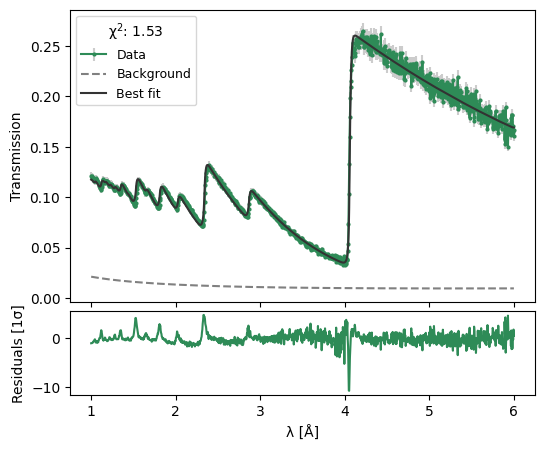

In [2]:
data = nbragg.Data.from_transmission("iron_powder.csv")                         # read data
xs = nbragg.CrossSection(iron="Fe_sg229_Iron-alpha.ncmat")                      # define sample
model = nbragg.TransmissionModel(xs,vary_background=True,vary_response=True)    # define model
result = model.fit(data)                                                        # perform fit
result.plot();                                                                  # plot results

In [3]:
result.params

name,value,standard error,relative error,initial value,min,max,vary
thickness,1.97199071,0.02039826,(1.03%),1.0,0.00000000,5.00000000,True
norm,0.78300297,0.00980447,(1.25%),1.0,0.10000000,10.0000000,True
temp,300.000000,0.00000000,(0.00%),300.0,77.0000000,1000.00000,False
α1,2.58187465,0.06907095,(2.68%),3.67,1.0000e-03,5.00000000,True
β1,3.82821870,0.12717649,(3.32%),3.06,1.0000e-03,5.00000000,True
b0,-0.02214306,0.00722157,(32.61%),0.0,-1.00000000,1.00000000,True
b1,0.00684791,0.00222354,(32.47%),0.0,-1.00000000,1.00000000,True
b2,0.03639766,0.00512518,(14.08%),0.0,-1.00000000,1.00000000,True


# Load data
Use the `nbragg.Data` object to read bragg edge data

In [4]:
data = nbragg.Data.from_transmission("iron_powder.csv")

The data is accessible as a table using `nbragg.Data.table`. An automatic plot is generated using the `nbragg.Data.plot` method.

In [5]:
data.table

,wavelength,trans,err
0,0.501098,0.148315,0.004449
1,0.505493,0.147728,0.004432
2,0.509889,0.147725,0.004432
3,0.514284,0.148043,0.004441
4,0.518680,0.148369,0.004451
...,...,...,...
2156,9.977258,0.050633,0.001519
2157,9.982328,0.043011,0.001291
2158,9.986135,0.103448,0.003104
2159,9.991219,0.062500,0.001875


<Axes: xlabel='wavelength [Å]', ylabel='Transmission'>

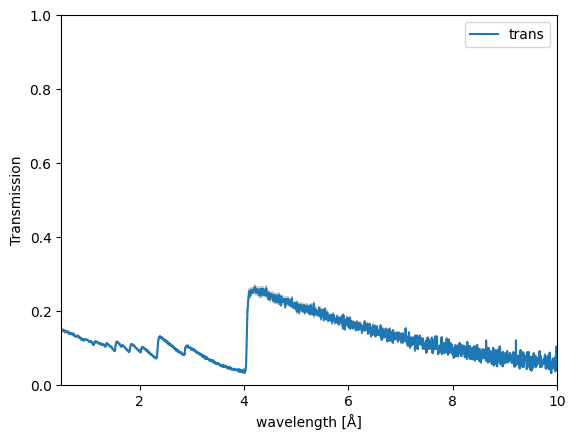

In [6]:
data.plot()

## Define samples
In this step the user defines the composition of the sample. You can choose from a variety of predefined crystalline materials from the `ncrystal` standard library, that is available under the `nbragg.materials` dictionary.

In [7]:
nbragg.materials["AgBr_sg225_SilverBromide.ncmat"]

{'name': 'SilverBromide',
 'mat': 'AgBr_sg225_SilverBromide.ncmat',
 'formula': 'AgBr',
 'space_group': 'sg225'}

Use the `nbragg.CrossSection method to upload a single material from the standard library

In [10]:
gamma = nbragg.CrossSection(gamma=nbragg.materials["Fe_sg225_Iron-gamma.ncmat"])
alpha = nbragg.CrossSection(alpha=nbragg.materials["Fe_sg229_Iron-alpha.ncmat"])

You can also register new `.ncmat` files into the ncrystal library using the `nbragg.utils.register_material` and upload them in the same way.

In [12]:
nbragg.utils.register_material("Fe_sg229_Iron-alpha_LGS.ncmat")
alphaLGS = nbragg.CrossSection(alpha=nbragg.materials["Fe_sg229_Iron-alpha_LGS.ncmat"])

You can easily combine materials simply by adding them together. Check the ncrystal cfg_string that uses the phases keyword to define a multiphase material

In [13]:
xs = alpha + gamma

# or

xs = alpha*0.3 + gamma*0.7

In [14]:
xs.cfg_string

'phases<0.5*Fe_sg229_Iron-alpha.ncmat;temp=300.0K&0.5*Fe_sg225_Iron-gamma.ncmat;temp=300.0K>'

The cross section data can be accessed through `nbragg.CrossSection.table` and plotted using the `nbragg.CrossSection.plot` method

In [15]:
xs.table

,alpha,gamma,total
wavelength,,,
1.00,12.295385,12.428371,12.360642
1.01,12.416298,12.511480,12.463004
1.02,12.417513,12.444117,12.430568
1.03,12.541085,12.208773,12.378017
1.04,12.666988,12.289012,12.481513
...,...,...,...
9.95,15.322888,15.548666,15.433679
9.96,15.337758,15.563652,15.448606
9.97,15.352626,15.578636,15.463531


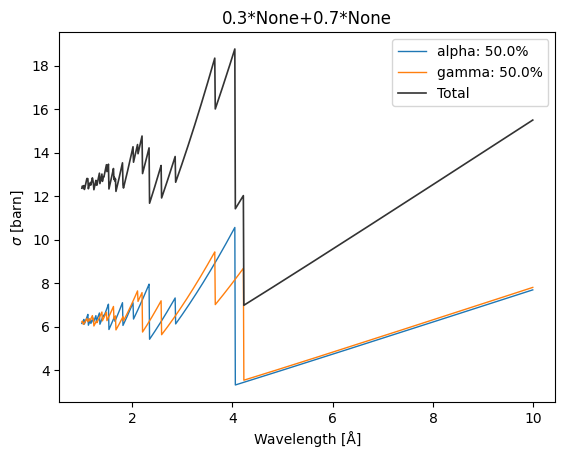

In [16]:
xs.plot();

# Define a transmission model
Next step is to define a model and adjust model parameters. The fit process in nbragg is based the super friendly package `lmfit`.

Defining a transmission model requires providing the `nbragg.CrossSection` object you created, as well as few flags in case you are interested in including non-default parameters to the model. In this example we define a model and request to vary background and response parameters.

In [46]:
model = nbragg.TransmissionModel(alpha,background="polynomial3",vary_background=True,vary_response=True,vary_tof=True)

In [47]:
model.params

name,value,initial value,min,max,vary
thickness,1.00000000,None,-inf,inf,True
norm,1.00000000,None,-inf,inf,True
L0,1.00000000,1.0,0.50000000,1.50000000,True
t0,0.00000000,0.0,-inf,inf,True
α1,3.67000000,3.67,-inf,inf,True
β1,3.06000000,3.06,-inf,inf,True
b0,0.00000000,0.0,-inf,inf,True
b1,0.00000000,0.0,-inf,inf,True
b2,0.00000000,0.0,-inf,inf,True


In [48]:
result = model.fit(data,wlmin=1,wlmax=5)

array([<Axes: ylabel='Transmission'>,
       <Axes: xlabel='λ [Å]', ylabel='Residuals [1σ]'>], dtype=object)

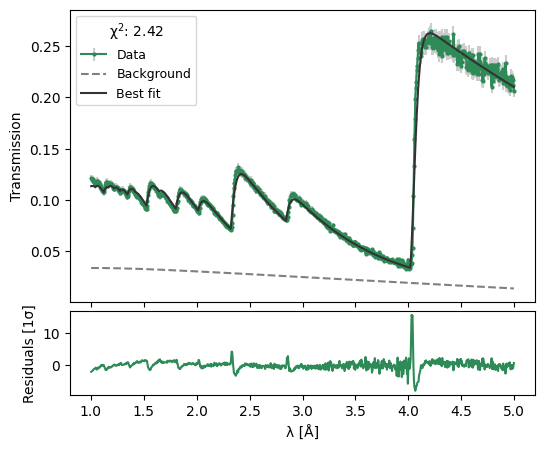

In [49]:
result.plot()

In [50]:
result